In [307]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import random
from skimage import io
import heapq

import networkx as nx

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



Circular Track Sanity Check

Separate representation of the board from the logic.
Each lane is a 1D NaSch sim

In [308]:
class Lane:
    # a 1D Nagel-Schreckenberg simulation using Cars
    def __init__(self, name, road_length = 100, car_density = 0.7, max_speed = 20, prob_slow = 0.2, anchor = 50, direction = 'NS', batch = False) -> None:
        
        self.name = name
        self.road_length = road_length

        self.direction = direction
        self.anchor = anchor
        
        self.curr_time  = 0
        self.state = True

        self.batch = batch

        self.representation = np.full(self.road_length, -1, dtype=int)
        # For diagnostics
        self.previous_states = []

        self.flows = []

        # Init cars or road based on Lane params // speeed limits vary by lane
        self.car_density = car_density

        # in m/s
        self.max_speed = self.to_ms(max_speed)
        self.prob_slow = prob_slow

        self.cars = []
        car_idxs = np.random.choice(
                range(self.road_length),
                size=int(round(car_density * self.road_length)),
                replace=False)

        for i in car_idxs:
            velocity_i = np.random.randint(0 , self.max_speed + 1)
            new_car = Car(position = i,
                        velocity = velocity_i,
                        max_speed = self.max_speed, 
                        prob_slow = self.prob_slow)
            self.cars.append(new_car)

    def calc_flow(self):
        # Calculate Average flow at a time step
        rep = self.representation

        n_cars = sum(rep != -1)
        sum_speeds = sum(rep[rep != -1])

        if n_cars > 0:
            avg_speed = sum_speeds/n_cars
        else:
            avg_speed = 0
        density = n_cars/len(rep)

        flow = avg_speed * density

        self.flows.append(flow)
        return flow

    def to_ms(self, kmph):
        return kmph / 3.6

    def update(self, graph):
        # Calculate the next position
        cars_ = sorted(self.cars)
        MAX = self.road_length

        if len(cars_) > 1:

            for i, car in enumerate(cars_):
                # Distance to nearest car, or other object
                try: 
                    next_car  = cars_[(i + 1)]
                    dist = (next_car.position - car.position) % self.road_length
                except:
                    dist = MAX

                car.calc_next_velocity(dist)

        elif len(cars_) == 1:
            cars_[0].calc_next_velocity(MAX)

        else: 
            # do nothing
            return

        # update to next_pos
        for car in self.cars:
            # Move along road, or pass to another Node
            car.update_position(max_length = self.road_length, 
                                curr_node  = self,
                                graph      = graph)

        # Update representation for visualization
        # At each step for space-time

        if self.batch:
            if self.curr_time // 60 == 0:
                self.set_representation()
                self.calc_flow()
        else:
            self.set_representation()
            self.calc_flow()

    def update_time(self, sim_time):
        self.curr_time = sim_time

    ### Utils

    def nearest_car(self, position = 5):
        
        car_pos = [car.position for car in self.cars]
        car_pos = np.array(car_pos)

        idx = (np.abs(car_pos - position)).argmin()

        return car_pos[idx]

    ########## Visualization

    def set_representation(self):
        # get positions of cars, set index
        # A check that car indices are bounded well
        new_representation = np.full(self.road_length, -1, dtype=int)

        for car in self.cars:
            car_idx = car.position
            car_vel = car.velocity

            new_representation[car_idx] = car_vel

        self.previous_states.append(new_representation)
        self.representation = new_representation

        return

    def show_lane(self, axs = False):

        prev = self.previous_states

        if axs: 
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = axs.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')
                axs.set_yticks(range(len(prev)))
                axs.set_title(f'{self.name} after {self.curr_time} Steps')

                axs.set_ylabel('Time')
                axs.set_xlabel('Space')


                plt.gca().invert_yaxis()
                #axs.xaxis.tick_top()

                plt.tick_params(
                    axis='y',         
                    which='both',      
                    bottom=False,     
                    top=False,         
                    labelbottom=False)

                sm = plt.cm.ScalarMappable(cmap='bone', norm=plt.Normalize(vmin = 0, vmax= 5))
                plt.colorbar(sm)
        else:
            fig, ax  = plt.subplots(1,1, figsize= (3,3))
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

            ax.set_yticks(range(len(prev)))

            ax.set_title(f'{self.name} after {self.curr_time} Steps')

            ax.set_ylabel('Time')
            ax.set_xlabel('Space')

            plt.gca().invert_yaxis()

            plt.tick_params(
                axis='y',         
                which='both',      
                bottom=False,     
                top=False,         
                labelbottom=False)

            sm = plt.cm.ScalarMappable(cmap='bone_r', norm=plt.Normalize(vmin = 0, vmax= 5))
            plt.colorbar(sm)
        return 


class Environment:
    # Variables of sim and current time
    def __init__(self, road_length, car_density, max_speed, prob_slow, n_lanes = 1) -> None:
        self.curr_time = 0

        self.lanes = []

        if n_lanes > 1:

            anchors = np.random.choice(np.arange(0,road_length), size = n_lanes, replace = False)
            directions = np.random.choice(["NS", "EW", "WE", "SN"], size = n_lanes, replace = True)

            for i in range(n_lanes):
                new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = anchors[i], 
                                direction = directions[i])
                self.lanes.append(new_lane)

        else: 
            new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = 50, 
                                direction = "NS")
            self.lanes.append(new_lane)

        self.env_rep = np.full((road_length, road_length), -2)

    def update(self):
        for lane in self.lanes:
            # update 
            lane.update(self)
            lane.update_time(self.curr_time)
        # increment time
        self.curr_time += 1


    # TODO: invert SN and WE
    def update_representation(self):
        new_rep = self.env_rep.copy()

        for lane in self.lanes:
            if lane.direction == 'NS' or lane.direction == 'SN' :
                new_rep[:, lane.anchor] = lane.representation
            elif lane.direction == 'EW' or lane.direction == 'WE' :
                new_rep[lane.anchor, :] = lane.representation

        self.env_rep = new_rep

        return self.env_rep

    def show_board(self, ax = False):

        self.update_representation()
        
        if ax:
            return ax.imshow(self.env_rep, cmap = 'gray_r')
        else:
            return plt.imshow(self.env_rep, cmap = 'gray_r')
 
class Car:
    def __init__(self, position, velocity, max_speed, prob_slow) -> None:
        self.position = position
        self.velocity = velocity

        self.next_velocity = velocity
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.history = []

    def __lt__(self, other):
        return self.position < other.position

    def __repr__(self) -> str:
        return f'Car at {self.position} with {self.velocity} cells/step'   

    def calc_next_velocity(self, dist):

        # Acceleration
        if self.velocity < self.max_speed:
            self.next_velocity = self.velocity + 1

        # Slow down
        if self.next_velocity >= dist:
            self.next_velocity = dist - 1

        # Random Transition Probability
        if self.next_velocity > 0:
            gamble = np.random.random() < self.prob_slow
            if gamble:
                self.next_velocity -= 1

        
    
    def update_position(self, max_length , curr_node = None, graph = None ,loop = False):
        
        self.velocity = self.next_velocity

        if self.velocity < 0:
            raise ValueError

        if loop:
            self.position += self.velocity
            self.position %= max_length
        else:
            # for graph implementation 
            proposed_position = self.position + self.velocity

            sim_graph =  graph.graph

            # At intersections
            if proposed_position >= (max_length - 1):
                
                # node car is at
                car_node = curr_node.name
                # Traffic Light functionality: proceed only if self.phase == True  (Green)
                if curr_node.state:

                    # get a list of outgoing edges from current node
                    out_edges = list(sim_graph.out_edges(car_node))
                    # get list of target nodes
                    potential_nodes = [i[1] for i in out_edges]

                    # (Old:) Traffic Light functionality: filter if Green ie phase == True
                    # green_nodes = [i for i in potential_nodes if sim_graph.nodes[i]['data'].state]

                    if len(potential_nodes) >= 1:
                        # Pop off the current lane
                        curr_node.cars.remove(self)
                        # push onto target node
                        target_node = np.random.choice(potential_nodes)
                        # classes are stored as node data
                        target_class = sim_graph.nodes[target_node]['data']

                        proposed_new_pos = (proposed_position - (max_length - 1))

                        if len(target_class.cars) == 0:
                            # if there are no cars, push
                            self.position = proposed_new_pos
                            target_class.cars.append(self)

                        else:
                            # Is loc free?
                            while (proposed_new_pos == target_class.nearest_car(proposed_new_pos)) and \
                                (proposed_new_pos >= 0):
                                proposed_new_pos -= 1
                            
                            # no spots found, stay here
                            if proposed_new_pos < 0:
                                # putt back into lane
                                curr_node.cars.append(self)
                                return

                            # if its empty, push it
                            self.position = proposed_new_pos
                            target_class.cars.append(self)
                    else: 
                        # Nowhere to go in potential nodes, so stay put
                        return
            # Update Position
            else:                
                self.position += self.velocity

                if self.position < 0:
                    raise IndexError
        
        #self.history.append(self.velocity)




In [309]:
class GraphSim:
    def __init__(self, seconds = 60*60, phase = [25,25] ,lanes = [], traffic_lights = [], batch = False) -> None:

        self.curr_time  = 0
        self.graph = nx.DiGraph()
        self.seconds = seconds
        self.phase = phase

        # Oranien default
        if len(lanes) == 0:
            self.lanes = [
                Lane('Oranien_1', 150, 0.4, 20),
                Lane('Oranien_2', 150, 0.4, 20),
                Lane('Oranien_3', 130, 0.4, 20),
                Lane('Oranien_4', 85, 0.4, 20),
                Lane('Oranien_5', 55, 0.4, 20),
                Lane('Oranien_6', 150, 0.4, 20),
                Lane('Oranien_7', 160, 0.4, 20),

                Lane("Dresden_1", 50, 0.2, 15),
                Lane('Dresden_2', 100, 0.2, 15),

                Lane('Orplatz_1', 200, 0.3, 30),
                Lane('Orplatz_2', 200, 0.3, 30),
                Lane('Orplatz_3', 150, 0.3, 30),
                Lane('Orplatz_4', 35, 0.3, 30),
                Lane('Orplatz_5', 115, 0.3, 30),
            ]
        else:
            self.lanes = lanes

        if batch:
            for lane in self.lanes:
                lane.batch = batch

        # For single Lane flow test

        self.terminals = []
        self.generators = []
        if len(traffic_lights) == 0:
            # Empirical: 25s per switch
            self.traffic_lights = [
                TrafficLight(
                    # Oranien_1, Oranien_3
                    sys_lanes = [self.lanes[0], self.lanes[2]],
                    # Orplatz 1
                    dy_lanes  = [self.lanes[9]],
                    ticks = self.phase[0]
                ),
                TrafficLight(
                    # Oranien 5, Oranien 6
                    sys_lanes = [self.lanes[4], self.lanes[5]],
                    # Orplatz 4
                    dy_lanes =  [self.lanes[12]],
                    ticks = self.phase[1]
                )
            ]
        else:
            self.traffic_lights = traffic_lights

    def get_lane_idx(self, lanes):
        lanes = []
        for i in lanes:
            try:
                index = [i.name for i in self.lanes].index(i)
                lanes.append(self.lanes[index])
                print(index)
            except:
                IndexError("Missing Lane")
        
        return lanes
                

    def wire_graph(self):
        for lane in self.lanes:
            self.graph.add_node(lane.name, data = lane)

        # A slightly better API of just specifying outgoing edges (intersections)
        edges = [
            ('Oranien_1', ['Oranien_4', 'Orplatz_3']),
            ('Orplatz_1', ['Oranien_2', 'Orplatz_3', 'Oranien_4']),
            ('Oranien_3', ['Oranien_2', 'Orplatz_3']),
            ('Oranien_4', ['Oranien_5', 'Dresden_1']),
            ('Orplatz_4', ['Orplatz_2', 'Oranien_7']),
            ('Dresden_1', ['Dresden_2', 'Orplatz_4']),
            ('Orplatz_5', ['Orplatz_4']),
            ('Oranien_5', ['Orplatz_2', 'Oranien_7']),
            ('Oranien_6', ['Orplatz_2', 'Oranien_3']),
        ]

        flat_edges = []

        for expanded_tuple in edges:
            for i in tuple(*expanded_tuple[1:]):
                flat_edges.append((expanded_tuple[0], i))

        self.graph.add_edges_from(flat_edges)
     
        # add Terminal nodes to Nodes without outgoing edges
        self.add_terminals()
        self.add_generator()

    def add_terminals(self):

        for node in list(self.graph.nodes):
            outgoing = list(self.graph.out_edges(node))

            if len(outgoing) == 0:
                # create a Terminal to hold exited cars
                new_terminal = Terminal()

                # add the Terminal
                self.terminals.append(new_terminal)
                new_terminal.name = f'Terminal {len(self.terminals)}'

                # Add to graph
                self.graph.add_node(new_terminal.name, data = new_terminal)
                self.graph.add_edge(node, new_terminal.name)

    def add_generator(self, target_road_node = None):
        # TODO: custom target_road_node
        # default: roads without incoming edges
        for node in list(self.graph.nodes):
            incoming = list(self.graph.in_edges(node))

            if len(incoming) == 0:
                # Add a generator for Cars
                new_generator  = Generator(arrival_rate=12)

                self.generators.append(new_generator)
                new_generator.name = f'Generator {len(self.generators)}'

                # Add to graph
                self.graph.add_node(new_generator.name, data = new_generator)
                self.graph.add_edge(new_generator.name, node)

    def update(self):
        # step lanes first so there is space
        for lane in self.lanes:
            # update 
            lane.update(self)
            lane.update_time(self.curr_time)
        
        # push cars into lanes
        for generator in self.generators:
            generator.update(self.curr_time, self)

        for traffic_light in self.traffic_lights:
            traffic_light.update()

    def run(self):
        for i in range(self.seconds):
            # increment time
            self.curr_time += 1
            self.update()

    ##################### Visualization #######################################################
    def show_graph(self, exits = False, colorbar = False):

        if exits:
            sizes = [len(self.graph.nodes[i]['data'].cars)*1 for i in self.graph.nodes]
            nx.draw_networkx(self.graph, node_size = sizes)
        else:
            # Visualize without Terminal and Generator
            plt.figure(figsize = (8,6), dpi = 80)

            H = nx.subgraph_view(self.graph, lambda n: 'Terminal' not in n and 'Generator' not in n )

            # Node Sizes ~ Number of Cars
            car_data  = np.array([len(H.nodes[i]['data'].cars) for i in H.nodes])

            sizes = car_data*10
            colors = car_data

            edge_cols = ['green' if g.graph.nodes[u]['data'].state else 'Red' for u,v in g.graph.edges]

            pos = nx.drawing.shell_layout(H)

            # Arrows red/green
            graph = nx.draw_networkx(
                H, 
                node_color = colors, 
                pos = pos,  
                node_size = sizes,
                font_size = 8,
                with_labels=True, 
                edge_color = edge_cols,
                cmap = 'gray_r',
                alpha = 0.7,
                vmin = -50,
                vmax = 200)

            plt.title(f"Roadway Network at t = {self.curr_time}s")

            if colorbar:
                sm = plt.cm.ScalarMappable(cmap='gray_r', norm=plt.Normalize(vmin = 0, vmax= 200))
                plt.colorbar(sm)


In [310]:
class Node:
    def __init__(self) -> None:
        # Collects Cars for data analysis
        self.cars = []
        self.name = ''
        self.state = True

class Terminal(Node):
    def __init__(self) -> None:
        super().__init__()

    def nearest_car(self, proposed_pos):
        # so cars will always push
        MAX = 10000
        return MAX

class Generator(Node):
    def __init__(self, arrival_rate = 1000) -> None:
        super().__init__()

        self.arrival_rate = arrival_rate
        self.curr_time = 0

        self.position = 0
        self.p = self.arrival_rate / 60

    
    # generate a Car, and push it onto the connected Node
    def generate_car(self, time):

        # TODO: creation time for Car
        time = time

        # at each step
        if random.random() < self.p:
            
            # to_do -> max_speed of connected Lane
            new_car = Car(position = self.position, 
                        velocity = np.random.randint(1,5),
                        max_speed = 5,
                        prob_slow= 0.3
                        )

            self.cars.append(new_car)
            

    def update(self, time, graph):
        # generate a car
        self.generate_car(time = time)

        if self.cars:
            self.cars[0].update_position(max_length = 0, curr_node = self, graph = graph)

        
    def get_lane_max(self, graph):
        return graph.out_edges(self)['data'].max_speed

class TrafficLight:
    def __init__(self, sys_lanes, dy_lanes, ticks =  100) -> None:

        self.sys_lanes = sys_lanes
        self.dy_lanes = dy_lanes



        for dy_lane in self.dy_lanes:
            dy_lane.state = not dy_lane.state

        self.ticks = ticks
        self.tick_counter = 0

    def update(self):
        self.tick_counter += 1

        # Phase ends, reset counter and switch lights
        if self.tick_counter == self.ticks:
            self.tick_counter = 0
            self.switch_signal()

    def switch_signal(self):
        
        for lane in self.sys_lanes:
            lane.state = not lane.state

        for lane in self.dy_lanes:
            lane.state = not lane.state



In [311]:
# get cars to flow from hien to ubahn to neumann
g = GraphSim(seconds = 60*60, phase = [20,25])

g.wire_graph()
g.run()

g.show_graph(exits=False, colorbar = True)



KeyboardInterrupt: 

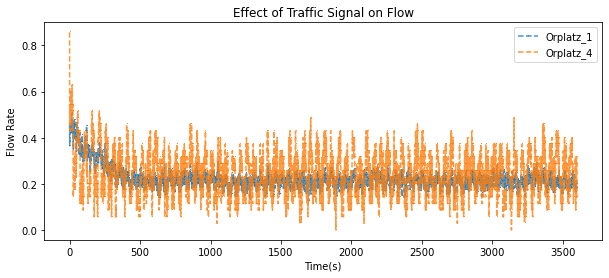

In [ ]:
plt.figure(figsize=(10,4))

# Flow Rate for 'off' lanes 
for lane in g.lanes:
    if lane.state == False:
        plt.plot(lane.flows, ',--', label = lane.name, alpha = 0.8)

plt.title('Effect of Traffic Signal on Flow')
plt.xlabel('Time(s)')
plt.ylabel('Flow Rate')
plt.legend()

In [312]:
phases = np.arange(10,60,10)
trials = 10

means = {k:[] for k in phases} 
stds = {k:[] for k in phases}

for phase_opt in phases:
    # For progress
    print(phase_opt/phases[-1])
    
    trial_results = []

    for i in range(trials):
        # Batch -> sample/min than /sec
        g = GraphSim(seconds = 60*60, phase = [phase_opt, phase_opt], batch = True)

        g.wire_graph()
        g.run()

        lanes_flow = []

        for lane in g.lanes:
            # collect last 5 minutes
            steady_state = lane.flows[-5:]
            mean_lane_flow = np.mean(steady_state)
        
            lanes_flow.append(mean_lane_flow)

        trial_results.append(lanes_flow)

    means[phase_opt] = np.mean(trial_results)
    stds[phase_opt] = np.std(trial_results)
            

0.2
0.4
0.6
0.8
1.0


Text(0.5, 1.0, 'Mean Flow Rate vs Phase Duration ')

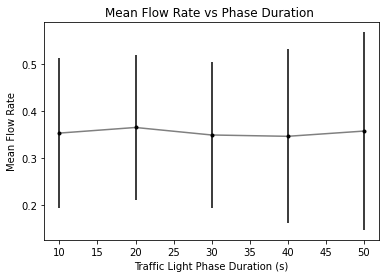

In [315]:
ci_width = [1.96*i for i in stds.values()]

plt.plot(means.keys(), means.values(), color = 'gray')
plt.errorbar(stds.keys(), means.values(), ci_width, fmt = '.k')
plt.xlabel("Traffic Light Phase Duration (s)")
plt.ylabel("Mean Flow Rate")
plt.title("Mean Flow Rate vs Phase Duration ")

In [319]:
# subgraph for Markov Model (see markov.py, run in Sage)
# Filter out all nodes without outgoing edges 
H = nx.subgraph_view(g.graph, lambda n: 'Terminal' not in n)

adj_mat = nx.linalg.adjacency_matrix(g.graph)

markov_mat = adj_mat.toarray()

markov_mat = markov_mat + np.eye(23) + markov_mat.T



# Add back to itself to get a valid graph
# 1s are ok as there is a fixed probability of transitioning, for all cars
#markov_mat = (markov_mat + markov_mat.T)

markov_mat

array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0.,